<a href="https://colab.research.google.com/github/Warckor/Coursera_Capstone/blob/main/Final_Assignment/House_Sales_Analytics_EN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Sales in Madrid
## Final Assignment
#### Miguel Gorostola Espadiña


## Introduction 

This is a project for the Capstone in the IBM Data Science certification. In it, I must use everything studied in the previous modules to generate a notebook that analyzes a business problem or, as in this case, a business search analysis.

>### A. Business Case
>
>>I am going to carry out a market study where we can analyze the evolution of the prices of homes and premises in Madrid (Spain) by square meters. For this, we are going to include the types of businesses that are in the surroundings of the main districts of Madrid.
>>
>>This is to obtain a classification to analyze the best area, or the area of ​​greatest interest, in case a stakeholder want to open a new business looking at the price of the district premises or for the type of businesses that are around.
>>
>>Firstly, I will carry out an analysis of the evolution of the average cost per square meter of the different districts of Madrid. With this, I will be able to visualize the upward or downward projection of the cost and assess which district would be more profitable in the future to buy a local.
>>
>>Later, I would be able to analyze by district:
>>
>>*   The cheapest area to buy a place for our new business.
>>*   The types of business that we find by districts.
>>*   Where we find a greater volume of business, which implies a greater amount of market activity.
>>*   In which district we are most likely to create a business that is not in the area, so that we can take advantage of the novelty.










>### B. Data
>
>> The data used for this study will be obtained from:
>>
>>*   Statistical Center of the Community of Madrid ([Madrid City Council](https://www.madrid.es/)): Dataset of the value of the square meter of the districts of the Madrid City Council for the year 2020.
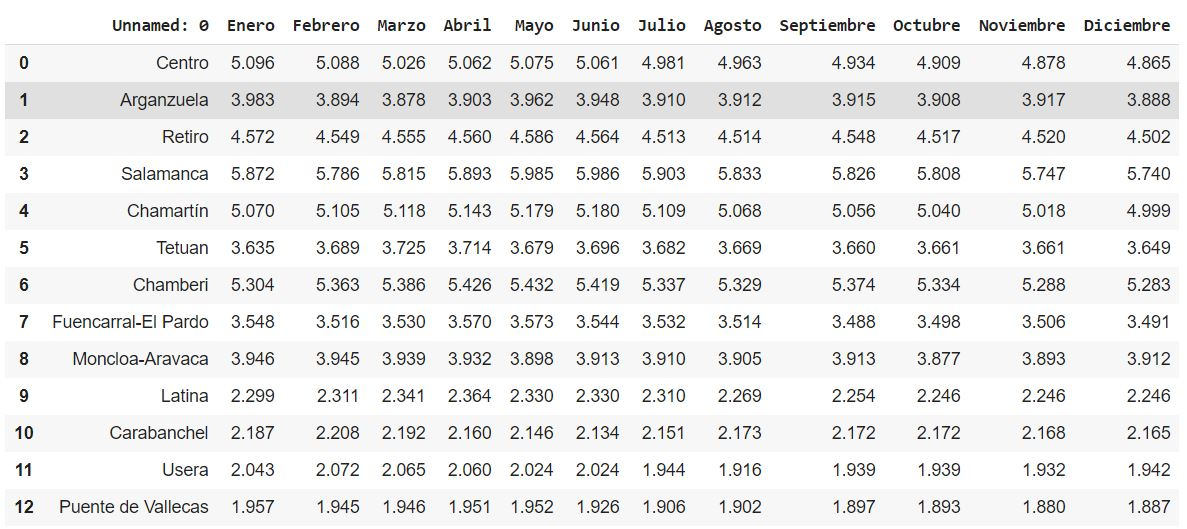
>>
>>
>>*   API Foursquare ([Foursquare](https://foursquare.com/)): I take advantage of this API to be able to obtain business from the avenues that are around the districts of Madrid, within a radius of 700 meters.
>>
>>
>>*   Using the *** geopy *** library we will use the *** Nominatim *** function to obtain the longitudes and latitudes of the districts that can be obtained with * OpenStreetMap *.



## Import Libraries

In [1]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

from geopy.geocoders import Nominatim
import folium

import requests

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

%matplotlib inline

## Data Load and Clean

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_rent = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Capstone IBM/Houses_Price.xlsx")
df_rent.head()

,Unnamed: 0,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre
0,Centro,5096,5088,5026,5062,5075,5061,4981,4963,4934,4909,4878,4865
1,Arganzuela,3983,3894,3878,3903,3962,3948,3910,3912,3915,3908,3917,3888
2,Retiro,4572,4549,4555,4560,4586,4564,4513,4514,4548,4517,4520,4502
3,Salamanca,5872,5786,5815,5893,5985,5986,5903,5833,5826,5808,5747,5740
4,Chamartín,5070,5105,5118,5143,5179,5180,5109,5068,5056,5040,5018,4999


In [4]:
df_rent.rename(columns={"Unnamed: 0":"Districts"}, inplace=True)
df_rent.columns

Index(['Districts', 'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
       'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'],
      dtype='object')

In [5]:
cols = df_rent.drop('Districts', axis=1)
cols = cols.columns.values

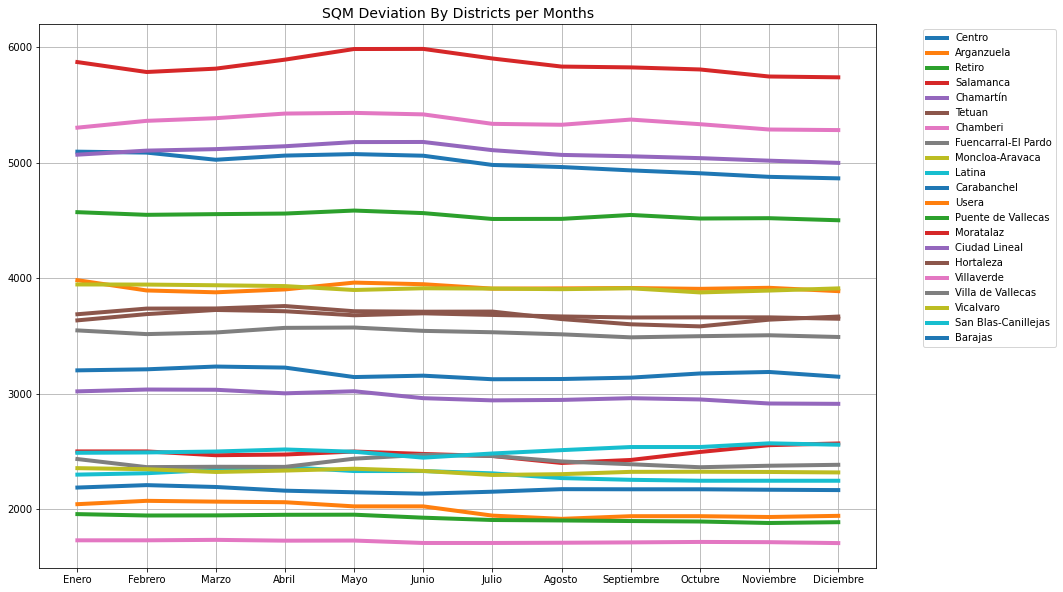

In [36]:
df_month = df_rent[cols].T

plt.figure(figsize=(15,10))

plt.plot(df_month, linewidth=4)
plt.legend(df_rent["Districts"], bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("SQM Deviation By Districts per Months", fontdict={'fontsize':14})
plt.grid()
plt.show()

Se puede visualizar que en los distritos más caros existe un pequeño descenso en el coste por metro cuadrado desde el comienzo del año hasta el final, mientras que en los distritos más baratos no existe mucha variacion. 

Esto es debido al inicio de la pandemia del COVID-19, donde se ha ralentizado el mercado, inclusive en casas y locales de negocio.

Vamos a seguir analizando el mercado sobre el mes de diciembre, valor más reciente obtenido del centro de estadística del Ayuntamiento de Madrid.

In [7]:
df_last = df_rent[["Districts", "Diciembre"]].copy()
df_last.rename(columns={"Diciembre":"Cost SQM"}, inplace=True)
df_last.sort_values("Cost SQM", ascending=False, inplace=True, ignore_index=True)
df_last.head()

,Districts,Cost SQM
0,Salamanca,5740
1,Chamberi,5283
2,Chamartín,4999
3,Centro,4865
4,Retiro,4502


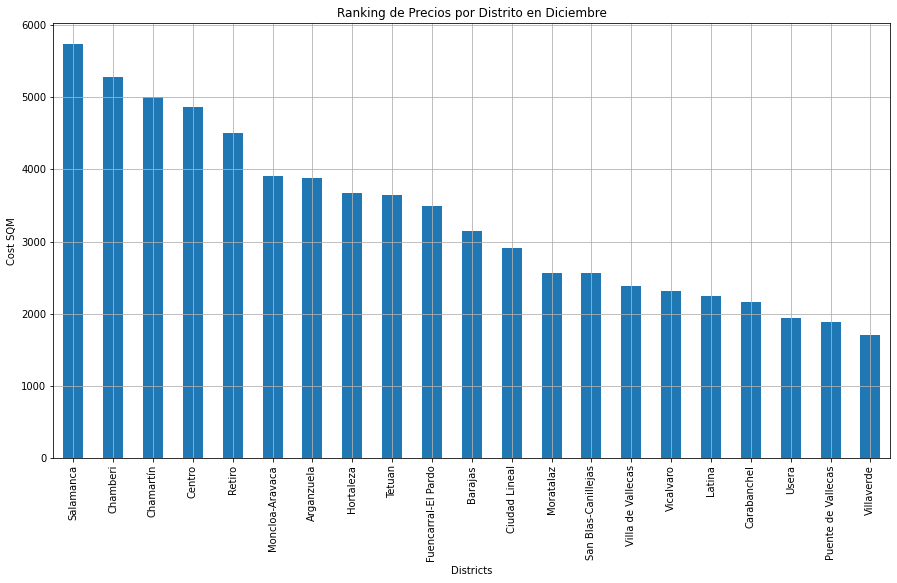

In [8]:
df_last.plot(kind="bar", x="Districts", y="Cost SQM", legend=False, title="Ranking de Precios por Distrito en Diciembre", 
             xlabel="Districts", ylabel="Cost SQM", grid=True, figsize=(15,8))

## Dataset Coordinates

In [9]:
geo = Nominatim(user_agent="Madrid_Districts")

In [10]:
dist = df_last.Districts
latitude = []
longitude = []
for d in dist:
  latitude.append(geo.geocode(d + ", Madrid").latitude)
  longitude.append(geo.geocode(d + ", Madrid").longitude)

In [11]:
df_last['Latitude'] = latitude
df_last['Longitude'] = longitude

In [12]:
df_last.head()

,Districts,Cost SQM,Latitude,Longitude
0,Salamanca,5740,40.427045,-3.680602
1,Chamberi,5283,40.436247,-3.703830
2,Chamartín,4999,40.458987,-3.676129
3,Centro,4865,40.417653,-3.707914
4,Retiro,4502,40.411150,-3.676057


In [13]:
madrid_lat = geo.geocode("Madrid, Spain").latitude
madrid_lon = geo.geocode("Madrid, Spain").longitude

In [14]:
f = folium.Figure(width=700, height=600)
map_madrid = folium.Map(location=[madrid_lat, madrid_lon], zoom_start=11, tiles="Stamen Terrain").add_to(f)

# add markers to map
for lat, lng, district, cost in zip(df_last['Latitude'], df_last['Longitude'], df_last['Districts'], df_last['Cost SQM']):
    label = '{}, {}'.format(district, cost)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid)  

map_madrid

## Foursquare API Venue Categories

In [15]:
CLIENT_ID = 'ELCWUWN02VV0OTPNCMRQMUYYJ1NK51RBMKUWUO11NW1S40QR'
CLIENT_SECRET = 'SN0SN255LEFEZRVKV4K5JLNAMSKBA3VVUTO50UVU2P0ZTL5B'
VERSION = '20180605'
LIMIT = 100

In [16]:
def getNearbyVenues(names, cost, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, cost, lat, lng in zip(names, cost, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            cost,
            lat, 
            lng, 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Districts',
                             'Cost SQM',
                             'Latitude', 
                             'Longitude', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

In [17]:
madrid_venues = getNearbyVenues(names=df_last['Districts'],
                                   cost=df_last['Cost SQM'],
                                   latitudes=df_last['Latitude'],
                                   longitudes=df_last['Longitude']
                                  )

In [18]:
madrid_venues.head()

,Districts,Cost SQM,Latitude,Longitude,Venue Latitude,Venue Longitude,Venue Category
0,Salamanca,5740,40.427045,-3.680602,40.426132,-3.678594,Juice Bar
1,Salamanca,5740,40.427045,-3.680602,40.427188,-3.678429,Mediterranean Restaurant
2,Salamanca,5740,40.427045,-3.680602,40.427477,-3.683965,Spanish Restaurant
3,Salamanca,5740,40.427045,-3.680602,40.425140,-3.682377,Furniture / Home Store
4,Salamanca,5740,40.427045,-3.680602,40.429714,-3.681068,Lounge


### Twenty-Five Most Common Businesses

In [19]:
top_25 = madrid_venues['Venue Category'].value_counts().head(25)

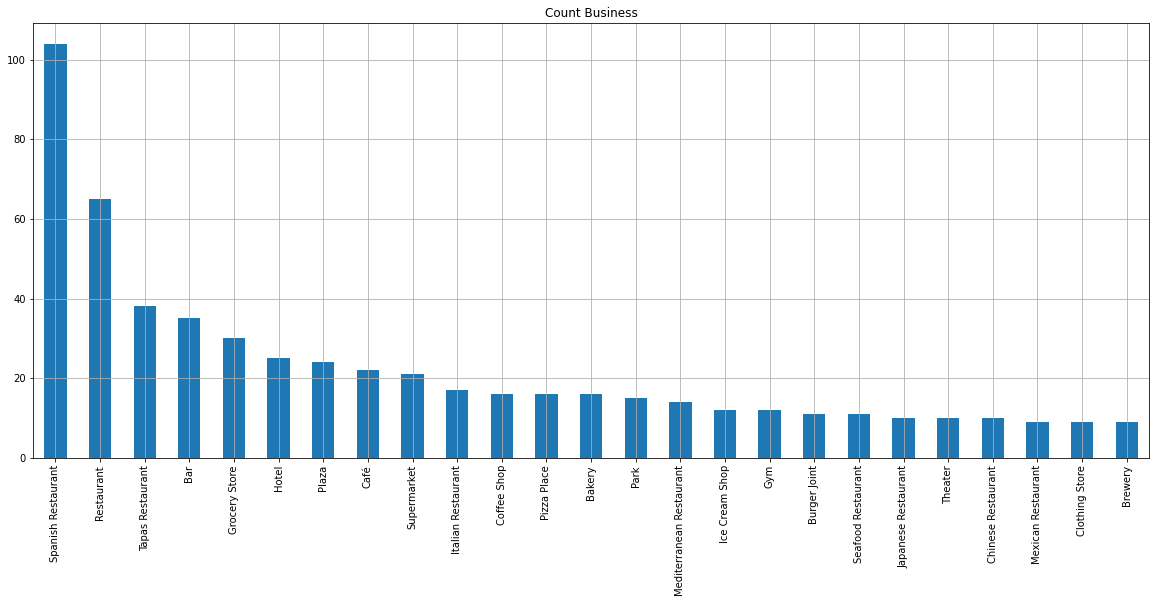

In [20]:
top_25.plot(kind="bar", legend=False, title="Count Business", grid=True, figsize=(20,8))

El sector que mas dinero mueve en Madrid es el Turismo y la hostelería, por lo que podemos ver que los negocios más populares entre todos los distritos son los restaurantes, los bares y los hoteles. 

También se puede observar un volumen menos grande en supermercados, cafeterías y restaurantes de otros paises.

In [21]:
madrid_venues_filtered = madrid_venues[madrid_venues['Venue Category'].isin(top_25.index.to_list())]
madrid_venues_filtered.head()

,Districts,Cost SQM,Latitude,Longitude,Venue Latitude,Venue Longitude,Venue Category
1,Salamanca,5740,40.427045,-3.680602,40.427188,-3.678429,Mediterranean Restaurant
2,Salamanca,5740,40.427045,-3.680602,40.427477,-3.683965,Spanish Restaurant
5,Salamanca,5740,40.427045,-3.680602,40.429144,-3.679790,Tapas Restaurant
6,Salamanca,5740,40.427045,-3.680602,40.424349,-3.679133,Burger Joint
7,Salamanca,5740,40.427045,-3.680602,40.425113,-3.682378,Ice Cream Shop


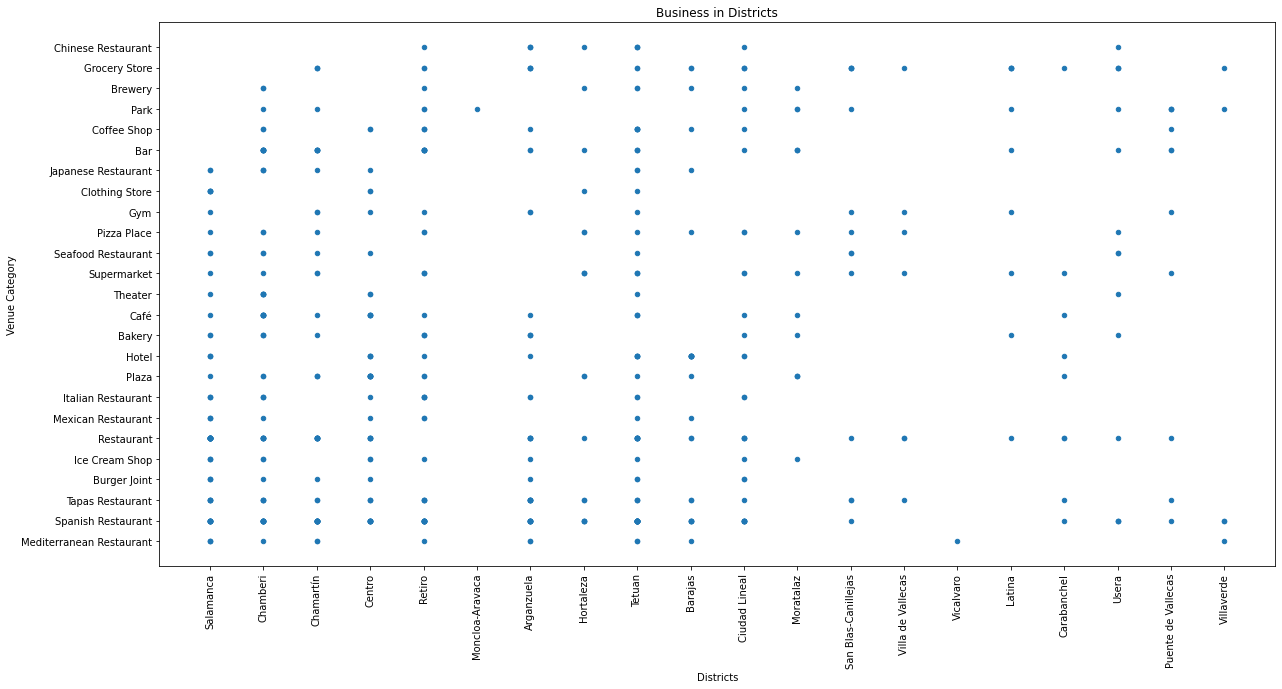

In [22]:
madrid_venues_filtered.plot(kind='scatter', x="Districts", y="Venue Category", 
                            figsize=(20, 10), rot=90, title="Business in Districts",
                            xlabel="Districts", ylabel="Business Categories")

Con esta gráfica podemos visualizar los distintos tipos de negocio que existen en cada distrito, de modo que nos permite valorar donde podemos empezar un nuevo negocio dentro de los 25 más populares donde no existen o cuales son los negocios más populares entre los distintos barrios.

In [23]:
madrid_dummies = pd.get_dummies(madrid_venues_filtered['Venue Category'])

In [24]:
madrid_grouped = pd.concat([madrid_venues_filtered[['Districts','Cost SQM']], madrid_dummies], axis=1)
madrid_grouped = madrid_grouped.groupby(["Districts", "Cost SQM"]).sum().reset_index()
madrid_grouped.sort_values("Cost SQM", ascending=False, inplace=True, ignore_index=True)

In [25]:
madrid_grouped.head()

,Districts,Cost SQM,Bakery,Bar,Brewery,Burger Joint,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Grocery Store,Gym,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Park,Pizza Place,Plaza,Restaurant,Seafood Restaurant,Spanish Restaurant,Supermarket,Tapas Restaurant,Theater
0,Salamanca,5740,2,0,0,3,1,0,5,0,0,1,3,3,3,2,3,3,0,1,1,16,2,10,1,5,1
1,Chamberi,5283,3,8,2,1,7,0,0,2,0,0,0,2,3,3,1,1,1,2,2,7,2,11,1,4,5
2,Chamartín,4999,1,6,0,1,1,0,0,0,3,2,0,0,0,1,2,0,1,1,3,9,1,13,2,2,0
3,Centro,4865,0,0,0,1,5,0,2,2,0,1,4,2,1,1,0,1,0,0,8,5,1,9,0,3,2
4,Retiro,4502,3,7,1,0,1,1,0,3,2,1,1,1,4,0,1,2,2,2,2,0,0,11,3,4,0


In [26]:
madrid_grouped.shape

(20, 27)

## KMeans Clustering

In [27]:
madrid_grouped_clustering = madrid_grouped.drop(["Districts", "Cost SQM"], axis=1)

In [28]:
inertias = []

K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, max_iter=500)
    kmeanModel.fit(madrid_grouped_clustering)

    inertias.append(kmeanModel.inertia_)

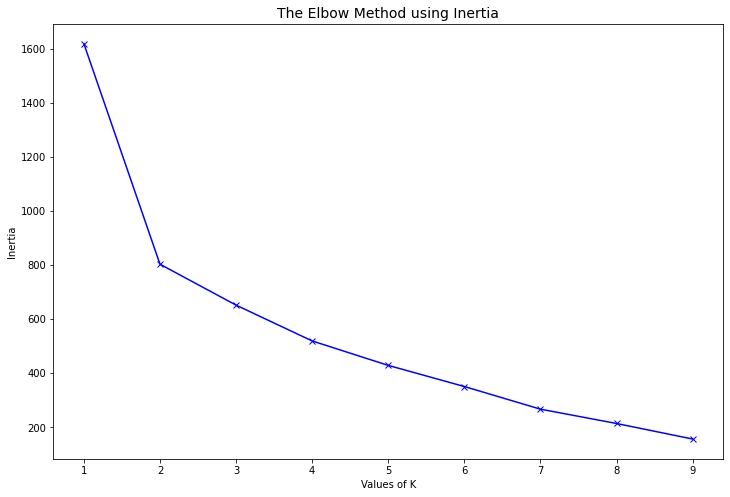

In [29]:
plt.figure(figsize=(12,8))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia', fontdict={'fontsize':14})
plt.show()

In [30]:
# set number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_grouped_clustering)

In [31]:
# add clustering labels
madrid_grouped_clustering = madrid_grouped.copy()
madrid_grouped_clustering.insert(2, 'Cluster Labels', kmeans.labels_)

In [32]:
madrid_grouped_clustering["Total Business"] = madrid_grouped_clustering.drop(["Districts","Cost SQM"], axis=1).sum(1).astype(int)

## Results

In [33]:
madrid_grouped_clustering

,Districts,Cost SQM,Cluster Labels,Bakery,Bar,Brewery,Burger Joint,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Grocery Store,Gym,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Park,Pizza Place,Plaza,Restaurant,Seafood Restaurant,Spanish Restaurant,Supermarket,Tapas Restaurant,Theater,Total Business
0,Salamanca,5740,1,2,0,0,3,1,0,5,0,0,1,3,3,3,2,3,3,0,1,1,16,2,10,1,5,1,67
1,Chamberi,5283,1,3,8,2,1,7,0,0,2,0,0,0,2,3,3,1,1,1,2,2,7,2,11,1,4,5,69
2,Chamartín,4999,1,1,6,0,1,1,0,0,0,3,2,0,0,0,1,2,0,1,1,3,9,1,13,2,2,0,50
3,Centro,4865,1,0,0,0,1,5,0,2,2,0,1,4,2,1,1,0,1,0,0,8,5,1,9,0,3,2,49
4,Retiro,4502,1,3,7,1,0,1,1,0,3,2,1,1,1,4,0,1,2,2,2,2,0,0,11,3,4,0,53
5,Moncloa-Aravaca,3912,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
6,Arganzuela,3888,1,3,2,0,1,1,3,0,1,4,2,1,1,2,0,2,0,0,0,0,5,0,9,0,7,0,45
7,Hortaleza,3668,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,2,2,1,0,4,3,2,0,18
8,Tetuan,3649,1,0,3,2,2,3,3,1,5,2,1,5,1,2,2,2,1,0,1,1,8,1,17,3,3,1,71
9,Barajas,3147,0,0,0,1,0,0,0,0,1,2,0,8,0,0,1,1,1,0,1,1,2,0,5,0,2,0,26


In [34]:
f = folium.Figure(width=700, height=600)
map_cluster = folium.Map(location=[madrid_lat, madrid_lon], zoom_start=11, tiles="Stamen Terrain").add_to(f)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.autumn(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, district, cost, cluster, business in zip(df_last['Latitude'], df_last['Longitude'], 
                                             df_last['Districts'], df_last['Cost SQM'], 
                                             madrid_grouped_clustering["Cluster Labels"], madrid_grouped_clustering["Total Business"]):
    label = '{}, {}, {}, {}'.format(district, cost, business, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_cluster)  

map_cluster

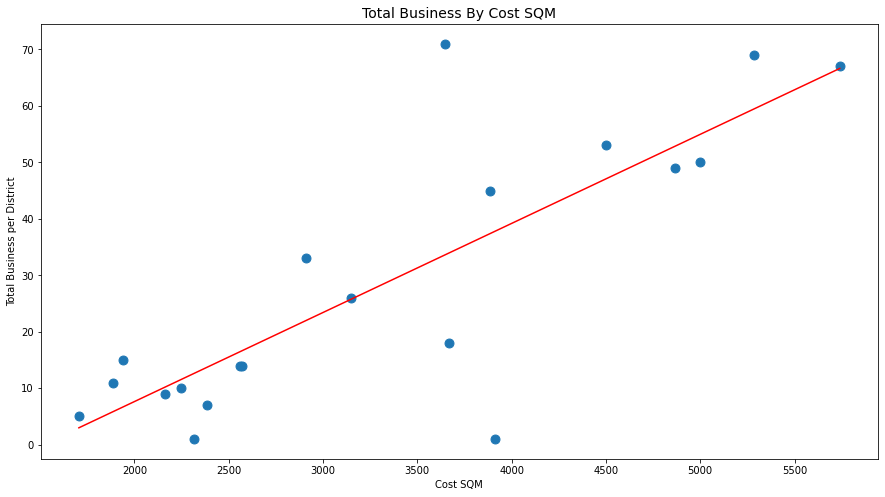

In [35]:
plt.figure(figsize=(15,8))

m, b = np.polyfit(madrid_grouped_clustering['Cost SQM'], madrid_grouped_clustering['Total Business'], 1)

plt.scatter(x=madrid_grouped_clustering['Cost SQM'], y=madrid_grouped_clustering['Total Business'], s=80)
plt.title("Total Business By Cost SQM", fontdict={'fontsize':14})
plt.xlabel("Cost SQM")
plt.ylabel("Total Business per District")

plt.plot(madrid_grouped_clustering['Cost SQM'], m * madrid_grouped_clustering['Cost SQM'] + b, 'r')

plt.show()

## Discussion

## Conclusion

## References